In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as ft
import glob

In [9]:
benign ='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
malignant='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
normal='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal'

In [10]:
count_benign=len(os.listdir(benign))
count_malignant=len(os.listdir(malignant))
count_normal=len(os.listdir(normal))

In [38]:
# Get the list of all the images
bening_cases = glob.glob(benign+ '/*')
malignant_cases =glob.glob(malignant+ '/*')
normal_cases = glob.glob(normal+ '/*')

# An empty list. We will insert the data into this list in (img_path, label) format
exclude=[]
train_data_mask = []
train_data_img=[]
# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    if img.endswith('_mask.png'):  
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else :
        train_data_img.append(img) 

# Go through all the bening cases. The label for these cases will be 1
for img in bening_cases:
    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

# Go through all the malignant cases. The label for these cases will be 1
for img in malignant_cases:

    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)


In [42]:
train_data_img = sorted(train_data_img)
train_data_mask = sorted(train_data_mask)

In [43]:
len(train_data_img), len(train_data_mask), len(exclude)

(780, 780, 18)

In [44]:
train_data_img[100]

'/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (19).png'

In [45]:
train_data_mask[100]

'/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (19)_mask.png'

In [46]:
images=[]
masks=[]
size_x=128
size_y=128

for every_img_path in train_data_img:
    img=cv2.imread(every_img_path,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(size_y, size_x))
    images.append(img)

for every_mask_path in train_data_mask:
    mask=cv2.imread(every_mask_path,0)
    mask=cv2.resize(mask,(size_y,size_x))
    masks.append(mask)
    
images = np.array(images)
masks = np.array(masks)

In [47]:
x=images/255
y=masks/255

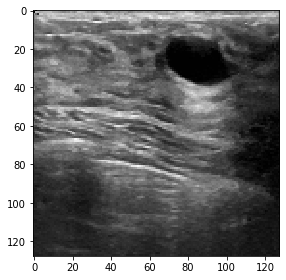

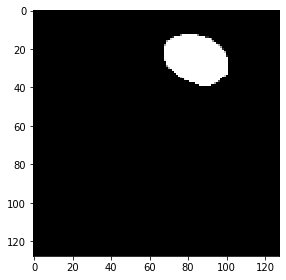

0.0 0.9725490196078431
(128, 128, 3)
0.0 1.0
(128, 128)


In [48]:
import random
from skimage.io import imshow

########## Displaying random image from X_train and Y_train ######### 
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show() 

test_img = x[random_num]
test_img2 = y[random_num]
print(test_img.min(), test_img.max())
print(test_img.shape)

print(test_img2.min(), test_img2.max())
print(test_img2.shape)

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [58]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()
    
    return model

In [59]:
def get_model():
    return simple_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [60]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
____________________________________________________________________________________________

In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

In [64]:
history=model.fit(x_train,
          y_train,
          batch_size=20, 
          epochs=50,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/50
32/32 [==============================] - 5s 84ms/step - loss: 0.1526 - mse: 0.0428 - val_loss: 0.1492 - val_mse: 0.0417
Epoch 2/50
32/32 [==============================] - 2s 51ms/step - loss: 0.1437 - mse: 0.0406 - val_loss: 0.1434 - val_mse: 0.0402
Epoch 3/50
32/32 [==============================] - 2s 57ms/step - loss: 0.1381 - mse: 0.0389 - val_loss: 0.1512 - val_mse: 0.0429
Epoch 4/50
32/32 [==============================] - 2s 51ms/step - loss: 0.1313 - mse: 0.0373 - val_loss: 0.1436 - val_mse: 0.0404
Epoch 5/50
32/32 [==============================] - 2s 51ms/step - loss: 0.1216 - mse: 0.0344 - val_loss: 0.1322 - val_mse: 0.0369
Epoch 6/50
32/32 [==============================] - 2s 51ms/step - loss: 0.1241 - mse: 0.0349 - val_loss: 0.1270 - val_mse: 0.0360
Epoch 7/50
32/32 [==============================] - 2s 51ms/step - loss: 0.1178 - mse: 0.0329 - val_loss: 0.1303 - val_mse: 0.0360
Epoch 8/50
32/32 [==============================] - 2s 51ms/step - loss: 0.1092 - m